<a href="https://colab.research.google.com/github/rsrikrishnan27/DS/blob/main/Hello_Watson_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis testing using NLI - BERT

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
pip install transformers 

In [ ]:
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
#To check if TPU is present 
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)


In [ ]:
#Load the dataset
train = pd.read_csv("train.csv")

0- entailment
1 - neutral
2 contradiction

In [ ]:
#initialise the pre-trainined model
model_name = 'bert-base-multilingual-cased'
#Initialise the tokeniser
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
#function to encode the sentence given as input
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))

   #SEP to separate the sentences
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

https://towardsdatascience.com/why-are-there-so-many-tokenization-methods-for-transformers-a340e493b3a8

tokeniser uses vocab.json to convert the extracted text into a numerical ID.

In [ ]:
#function to add mask, word_id
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  s1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  s2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*s1.shape[0]
  input_word_ids = tf.concat([cls, s1, s2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=[input_word_ids.shape[0], 259])

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(s1)
  type_s2 = tf.ones_like(s2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor(shape=[input_word_ids.shape[0], 259])

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=[input_word_ids.shape[0], 259]),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs


Attention mask helps the model to know the useful tokens and padding that is done during batch preparation. 

Attention mask is basically a sequence of 1’s with the same length as input tokens.

[CLS] This is a book [SEP] It has pages [SEP] = 10 posititions


In [ ]:
bert_encode(["This is a book"],["It has pages"],tokenizer)

{'input_mask': <tf.Tensor: shape=(1, 259), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shap

In [ ]:
#Encode the premise, hypothesis with the help of tokeniser 
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [ ]:
max_len = 259

#Initialise and compile the model
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")   
    
    #input layer
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    #output layer
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])   
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-6), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
#Build the model in TPU's scope
with strategy.scope():
    model = build_model()
    model.summary()


Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 259)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 259)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 259)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Fit the model
history = model.fit(train_input, train.label.values, epochs = 10, verbose = 1, batch_size = 64, validation_split = 0.3)

Epoch 1/10


76/76 [==============================] - 176s 1s/step - loss: 1.1123 - accuracy: 0.3637 - val_loss: 1.0774 - val_accuracy: 0.3959
Epoch 2/10
76/76 [==============================] - 16s 217ms/step - loss: 1.0757 - accuracy: 0.4057 - val_loss: 1.0527 - val_accuracy: 0.4474
Epoch 3/10
76/76 [==============================] - 17s 217ms/step - loss: 1.0514 - accuracy: 0.4462 - val_loss: 1.0282 - val_accuracy: 0.4774
Epoch 4/10
76/76 [==============================] - 17s 218ms/step - loss: 1.0186 - accuracy: 0.4866 - val_loss: 1.0041 - val_accuracy: 0.5163
Epoch 5/10
76/76 [==============================] - 17s 224ms/step - loss: 0.9855 - accuracy: 0.5128 - val_loss: 0.9659 - val_accuracy: 0.5444
Epoch 6/10
76/76 [==============================] - 17s 217ms/step - loss: 0.9451 - accuracy: 0.5548 - val_loss: 0.9282 - val_accuracy: 0.5682
Epoch 7/10
76/76 [==============================] - 16s 217ms/step - loss: 0.8992 - accuracy: 0.5837 - val_loss: 0.9068 - val_accuracy: 0.5881
Epoch 8/10
7

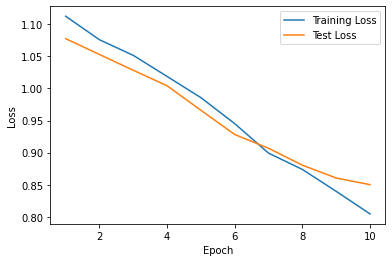

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss)
plt.plot(epoch_count, test_loss)
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

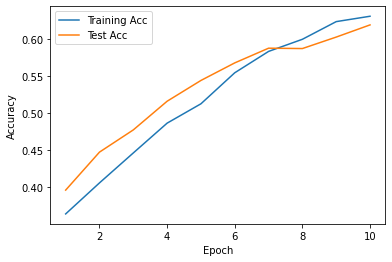

In [ ]:
# Get training and test loss histories
training_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss)
plt.plot(epoch_count, test_loss)
plt.legend(['Training Acc', 'Test Acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

Pracitcal test 1

In [ ]:
result = {0:'Entailment',1:'Neutral',2:'Contradiction'}
test_input = bert_encode(["The grass is dry"], ["It rained today"], tokenizer)
predict_x=model.predict(test_input) 
prediction=np.argmax(predict_x,axis=1)
print(result[prediction[0]])

Contradiction


Practical test 2

In [ ]:
test_input = bert_encode(["Are you proficient in Python?"], ["I had a Coffee"], tokenizer)
predict_x=model.predict(test_input) 
prediction=np.argmax(predict_x,axis=1)
print(result[prediction[0]])

Neutral


In [ ]:
predict_x=model.predict(train_input) 
prediction=np.argmax(predict_x,axis=1)

Metrics

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
cm1=confusion_matrix(train.label.values,prediction)

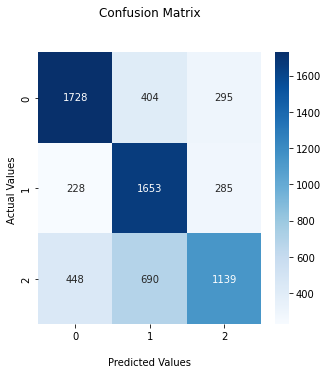

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
ax = sns.heatmap(cm1, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## labels 
plt.show()

In [ ]:
cr = classification_report(train.label.values,prediction)

In [ ]:
print(cr)

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      2427
           1       0.60      0.76      0.67      2166
           2       0.66      0.50      0.57      2277

    accuracy                           0.66      6870
   macro avg       0.66      0.66      0.65      6870
weighted avg       0.66      0.66      0.65      6870



References: 

https://towardsdatascience.com/why-are-there-so-many-tokenization-methods-for-transformers-a340e493b3a8

https://towardsdatascience.com/tokenization-for-natural-language-processing-a179a891bad4

https://towardsdatascience.com/understanding-bert-bidirectional-encoder-representations-from-transformers-45ee6cd51eef




